In [1]:
import os
from tqdm.autonotebook import tqdm, trange
import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline
mpl.style.use('tableau-colorblind10')

from copy import deepcopy

# import numba as nb
# nb.cuda.detect()
# import cupy as cp
# %pip install -q cudf-cu11 dask-cudf-cu11 --extra-index-url=https://pypi.ngc.nvidia.com
# import cudf as cd

current_dir = os.path.dirname(os.path.realpath('__file__'))
data_dir = os.path.join(current_dir, '..', '..', 'py', 'desiforecast', 'data')
nb_dir = current_dir

/tmp/ipykernel_248551/3738254455.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [5]:
# Original, unfiltered data as provided by the DESI telemetry database
tower_data = pd.read_pickle(f'{data_dir}/environmentmonitor_tower.pkl')
dome_data = pd.read_pickle(f'{data_dir}/environmentmonitor_dome.pkl')
telescope_data = pd.read_pickle(f'{data_dir}/environmentmonitor_telescope.pkl')

In [ ]:
# print(tower_data.columns)
# print(telescope_data.columns)
# print(dome_data.columns)

In [ ]:
# print(tower_data.index)
# print(telescope_data.index)
# print(dome_data.index)

In [42]:
def resample(data) -> pd.DataFrame :
    """Ramples DESI telemetry data contained within Pandas dataframe.
    
    Parameters
    ----------
    rows : numpy.ndarray
        Unprocessed data from the DESI telemetry database
    
    columns : list[str]
        column names that were queired from database
    
    Returns
    -------
    data : pandas.DataFrame
        Resampled and interpolated DESI telemetry data
    """
    # data.set_index('time_recorded', inplace=True)
    # try:
    #     assert((data.dtypes == np.float64).all())
    # except AssertionError:
    #     data = data.astype(np.float64)
    #     print(data.dtypes)
    data.interpolate(limit_direction='both', inplace=True)
    data = data.resample('6S').mean()
    data = data.tz_convert("America/Phoenix")
    return data

In [73]:
table_list = [ tower_data, dome_data, telescope_data ]
merged_data = resample(table_list.pop())
for i in range(len(table_list)):
    merged_data = pd.merge(merged_data, resample(table_list.pop()), left_index=True, right_index=True)
train = merged_data[merged_data['mirror_cooling']==1].resample('1D').mean()
train.interpolate(limit_direction='both', inplace=True)
for column in train.columns:
    train[column] = interpolate_outliers(train[column])
    
train.to_pickle(os.path.join(data_dir, 'neural_network_data.pkl'))

finding valid values: 0it [00:00, ?it/s]

finding valid values: 0it [00:00, ?it/s]

finding valid values: 0it [00:00, ?it/s]

/tmp/ipykernel_197489/4283976955.py:10: RuntimeWarning: invalid value encountered in true_divide
  where = np.argwhere(np.invert(np.logical_and(np.abs((test-mean)/std) < max_z, np.isfinite(test)))).flatten()


finding valid values:   0%|          | 0/841 [00:00<?, ?it/s]

/tmp/ipykernel_197489/4283976955.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs((test[i]-mean)/std) > max_z or not np.isfinite(test[i]):


finding valid values: 0it [00:00, ?it/s]

finding valid values:   0%|          | 0/1 [00:00<?, ?it/s]

finding valid values: 0it [00:00, ?it/s]

finding valid values: 0it [00:00, ?it/s]

finding valid values: 0it [00:00, ?it/s]

finding valid values: 0it [00:00, ?it/s]

finding valid values: 0it [00:00, ?it/s]

finding valid values: 0it [00:00, ?it/s]

finding valid values: 0it [00:00, ?it/s]

finding valid values:   0%|          | 0/8 [00:00<?, ?it/s]

finding valid values:   0%|          | 0/8 [00:00<?, ?it/s]

finding valid values:   0%|          | 0/8 [00:00<?, ?it/s]

finding valid values: 0it [00:00, ?it/s]

finding valid values: 0it [00:00, ?it/s]

finding valid values: 0it [00:00, ?it/s]

finding valid values:   0%|          | 0/2 [00:00<?, ?it/s]

finding valid values: 0it [00:00, ?it/s]

finding valid values:   0%|          | 0/1 [00:00<?, ?it/s]

finding valid values: 0it [00:00, ?it/s]

In [76]:
# print(train.columns)
# print(train.index)
# print(test.index)

Index(['mirror_avg_temp', 'mirror_desired_temp', 'mirror_temp',
       'mirror_cooling', 'air_temp', 'air_flow', 'air_dewpoint',
       'dome_left_upper', 'dome_left_lower', 'dome_right_upper',
       'dome_right_lower', 'dome_back_upper', 'dome_back_lower',
       'dome_floor_ne', 'dome_floor_nw', 'dome_floor_s', 'temperature',
       'pressure', 'humidity', 'wind_speed', 'wind_direction', 'dimm',
       'dewpoint'],
      dtype='object')
DatetimeIndex(['2020-11-04 00:00:00-07:00', '2020-11-05 00:00:00-07:00',
               '2020-11-06 00:00:00-07:00', '2020-11-07 00:00:00-07:00',
               '2020-11-08 00:00:00-07:00', '2020-11-09 00:00:00-07:00',
               '2020-11-10 00:00:00-07:00', '2020-11-11 00:00:00-07:00',
               '2020-11-12 00:00:00-07:00', '2020-11-13 00:00:00-07:00',
               ...
               '2023-02-12 00:00:00-07:00', '2023-02-13 00:00:00-07:00',
               '2023-02-14 00:00:00-07:00', '2023-02-15 00:00:00-07:00',
               '2023-02-16

In [3]:
def valid_values(data):
    data = np.asarray(data)
    arr = np.full((len(data)), False, dtype=bool)
    std = np.std(data[np.isfinite(data)])
    mean = np.mean(data[np.isfinite(data)])
    max_z = 5
    print(std)
    print(mean+(max_z*std))
    print(mean)
    print(mean-(max_z*std))
    for i in trange(len(data), desc='finding valid values'):
        if np.isfinite(data[i]) and np.abs((data[i]-mean)/std) < max_z:
            arr[i] = True
    return arr

In [77]:
def interpolate_outliers(data):
    test = np.array(data)
    
    std = np.std(test[np.isfinite(test)])
    mean = np.mean(test[np.isfinite(test)])
    max_z = 5

    where = np.argwhere(np.invert(np.logical_and(np.abs((test-mean)/std) < max_z, np.isfinite(test)))).flatten()
    for i in tqdm(where, desc='finding valid values'):
        if np.abs((test[i]-mean)/std) > max_z or not np.isfinite(test[i]):
            if i == 0:
                j = i + 1
                while np.abs((test[j]-mean)/std) > max_z or not np.isfinite(test[j]):
                    j += 1
                test[i] = test[j+1]
            if i == len(test)-1:
                k = i - 1
                while np.abs((test[k]-mean)/std) > max_z or not np.isfinite(test[k]):
                    k -= 1
                test[i] = test[k]
            else:
                j = i + 1
                while np.abs((test[j]-mean)/std) > max_z or not np.isfinite(test[j]):
                    j += 1
                k = i - 1
                while np.abs((test[k]-mean)/std) > max_z or not np.isfinite(test[k]):
                    k -= 1
                test[i] = (test[j]+test[k])/2
    return test

In [2]:
def resample(rows, columns):
    data = pd.DataFrame(rows)
    data.columns = columns
    # print('filled dataframe')
    data.set_index('time_recorded', inplace=True)
    data.sort_index(inplace=True)
    # print('sorted indicies')
    data = data.resample('6S').mean()
    data.interpolate(limit_direction='both', inplace=True)
    # print('resampled')
    # data = data.tz_convert("America/Phoenix")
    return data

In [ ]:
import torch
from torch import nn, zeros, tensor
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import dropout
from torch.autograd import Variable
from sklearn.model_selection import train_test_split

device = torch.device("cpu")

# initalize data
class Data(Dataset):
    def __init__(self, X, y, device):
        self.X = torch.from_numpy(X).to(device, dtype=torch.float32)
        self.y = torch.from_numpy(y).to(device, dtype=torch.float32)
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len

class NeuralNetwork(nn.Module):
    """Initializes and trains an LSTM RNN to predict future temperatures for the DESI experiment.
    """
    def __init__(self, input_size, layer1_size:int=128, layer2_size:int=32, stack_size:int=2, dropout:float=0.05):
        super(BayesianLSTM, self).__init__()
        self.hidden_layer1 = nn.LSTM(input_size, layer1_size, num_layers=stack_size, batch_first=True, dropout=dropout)
        self.hidden_layer2 = nn.LSTM(layer1_size, layer2_size, num_layers=stack_size, batch_first=True, dropout=dropout)
        self.output_layer = nn.Linear(layer2_size, 1)
        # self.layer_stack = nn.Sequential(
        #     nn.LSTM(self.input_size, self.layer1_size, num_layers=self.stack_size, batch_first=True, dropout=0.05),
        #     nn.LSTM(self.layer1_size, self.layer2_size, num_layers=self.stack_size, batch_first=True, dropout=0.05),
        #     nn.Linear(self.layer2_size, 1)
        #
        self.loss = nn.BCEWithLogitsLoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.1)

    def forward(self, data: torch.tensor, training: bool):
        """Executes a forward pass of the neural network.
        
        Parameters
        ----------
        data : torch.tensor
            input data (temperature, seeing, etc.)

        Returns
        -------
        output : torch.tensor
            temperature estimation
        """
        data = torch.tensor(data, dtype=torch.float32)
        data, _ = self.hidden_layer1(data)
        # data = torch.tensor(data, dtype=torch.float32)
        data, _ = self.hidden_layer2(data)
        output = self.output_layer(data)
        return output
    
    def load() -> None:
        """Loads the state dictionary of the neural network.

        Parameters
        ----------
        None
            
        Returns
        -------
        None
        """
        global data_dir
        
        filename = 'neural_network_model.pt'
        filepath = os.path.join(data_dir, filename)

        self.load_state_dict(torch.load(PATH))
        self.eval()
    
    def train(self, train_dataloader: Data, epochs: int=100) -> None:
        """Trains the neural network.

        Parameters
        ----------
        train_dataloader : Data
            Input telemetry data
        
        epochs : int
            Number of epochs to train on
            
        Returns
        -------
        None
        """
        global nb_dir
        
        loss_values = []
        for epoch in trange(epochs, desc="Training neural network"):
            for X, y in train_dataloader:
                self.optimizer.zero_grad()
                prediction = self(X, training=True)
                loss = self.loss(prediction.reshape(-1), y)
                loss_values.append(loss.item())
                loss.backward()
                self.optimizer.step()
        
        steps = np.linspace(0, epochs, len(loss_values))
        
        fig, ax = plt.subplots(figsize=(8,5))
        plt.plot(steps, np.array(loss_values))
        plt.title("Step-wise Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        save_dir = os.path.join(nb_dir, 'neural_network')
        if not os.path.isdir(save_dir):
            os.mkdir(save_dir)
        path = os.path.join(save_dir, 'neural_network_loss.png')
        plt.savefig(path)
        plt.show()
        plt.close(fig)
        
        self.save()
        return loss_values
        
    def save(self, filename='neural_network_model.pt') -> None:
        """Saves the state dictionary of the neural network.

        Parameters
        ----------
        filename : str
            Name of file to hold serialized neural network model.
            
        Returns
        -------
        None
        """
        global data_dir
        if '.' in filename:
            if filename[-3:] != '.pt':
                i = filename.index('.')
                filename = filename[:i]+'.pt'
        else:
            filename += '.pt'
        filepath = os.path.join(data_dir, filename)
        print('Saving trained model')
        torch.save(self.state_dict(), filepath)
    
    def predict(self, test_dataloader: Data) -> None:
        """Makes predictions using the trained neural network.

        Parameters
        ----------
        test_dataloader : Data
            Input telemetry data
            
        Returns
        -------
        loss_values : list[float]
            Test data loss values
        """
        loss_values = []
        with torch.no_grad():
            for X, y in tqdm(test_dataloader, desc="Making temperature predictions"):
                outputs = self(X, training=False)
                predicted = np.where(outputs < 0.5, 0, 1)
                predicted = list(itertools.chain(*predicted)) 
                loss = self.loss(predicted, y.unsqueeze(-1))
                loss_values.append(loss)
    
        steps = np.linspace(0, epochs, len(loss_list))
        
        fig, ax = plt.subplots(figsize=(8,5))
        plt.plot(steps, np.array(loss_values))
        plt.title("Step-wise Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        save_dir = os.path.join(nb_dir, 'neural_network')
        if not os.path.isdir(save_dir):
            os.mkdir(save_dir)
        path = os.path.join(save_dir, 'neural_network_loss.png')
        plt.savefig(path)
        plt.show()
        plt.close(fig)
        
        self.save()
        return loss_values

In [ ]:
model = NeuralNetwork(input_size=input_size).to(device)

Training neural network:   0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_248551/2139112446.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32)


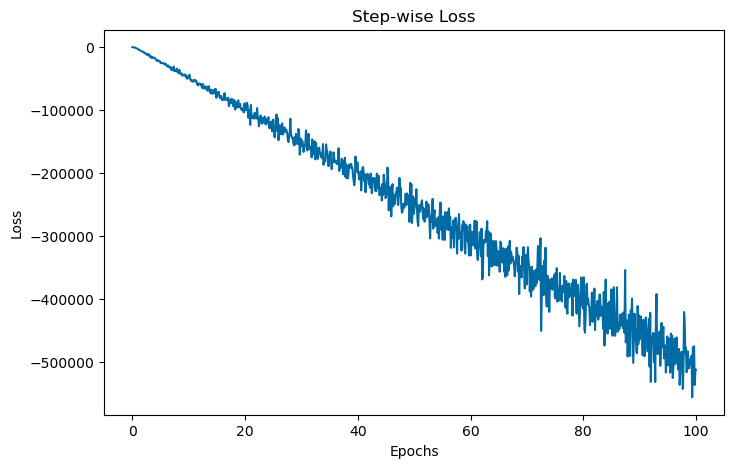

Saving trained model


In [82]:
train_loss = model.train(train_dataloader)

In [83]:
test_loss = model.predict(test_dataloader)

Making temperature predictions:   0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_248551/2139112446.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32)


NameError: name 'itertools' is not defined

In [84]:
asdf = np.zeros((64,1))
print(asdf.shape)
print(asdf.reshape(-1).shape)

(64, 1)
(64,)
